In [59]:
import torch
import numpy as np
import time
from PIL import Image
import skimage.segmentation
import skimage.color
import matplotlib.pyplot as plt
from pygco import cut_simple
import IPython.display as display
from tqdm import tqdm
import os
import evaluate
import pandas as pd

# Find fastest device available
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

# Select backend for JIT compilation based on device (inductor is best but MPS only supports aot_eager)
jit_backend = "aot_eager" if device == "mps" else "inductor"

print("Using device:", device)
print("Using JIT backend:", jit_backend)

Using device: mps
Using JIT backend: aot_eager


In [118]:
# Define CNN module for GNEMS to use
class GNEMNet(torch.nn.Module):
    def __init__(self, image_size=(32,32), k=10, n_filters=16, dropout=0.2):
        super(GNEMNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, n_filters, 3, padding=1)
        self.BN1 = torch.nn.BatchNorm2d(n_filters)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(n_filters, 1, 3, padding=1)
        self.BN2 = torch.nn.BatchNorm2d(1)
        self.dropout2 = torch.nn.Dropout(dropout)
        self.output = torch.nn.Linear(image_size[0] * image_size[1], k)

    def forward(self, x):
        x = self.conv1(x)
        x = self.BN1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = self.output(x)
        x = torch.softmax(x, dim=1)
        return x

class TileDS(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

In [228]:
def tile(image, d):
    assert image.shape[0] % d == 0 or image.shape[1] % d == 0 # Image dimensions must be divisible by d
    tile_width = (image.shape[0] // d)
    tile_height = (image.shape[1] // d)
    image_tensor = torch.tensor(image, dtype=torch.float32)
    if len(image_tensor.shape) < 3:
        image_tensor = image_tensor.unsqueeze(2)
    tiles = image_tensor.unfold(0, tile_width, tile_height).unfold(1, tile_width, tile_height)
    tiles = tiles.permute(0, 1, 3, 4, 2)
    tiles = tiles.reshape(tiles.shape[0] * tiles.shape[1], tile_width, tile_height, tiles.shape[4])
    return tiles

def initial_labels(image, d, n_segments, method="slic"):
    if method == "slic":
        seg = skimage.segmentation.slic(image, compactness=1, max_num_iter=10,
                                        n_segments=n_segments, start_label=0,
                                        enforce_connectivity=False, convert2lab=True)
        
        # while len(np.unique(seg)) > n_segments, merge smallest segments
        while len(np.unique(seg)) > n_segments:
            # count number of pixels in each segment
            segments, counts = np.unique(seg, return_counts=True)
            # find smallest segment
            smallest1 = segments[np.argmin(counts)]
            # find second smallest segment
            counts[smallest1] = np.max(counts)
            smallest2 = segments[np.argmin(counts)]
            # merge smallest segments
            seg[seg == smallest1] = smallest2

        t = torch.tensor(seg).unsqueeze(0).unsqueeze(0).float()
        labels = torch.nn.functional.interpolate(t, (d, d), mode="nearest")
        labels = labels.squeeze().to(torch.int64).reshape(d * d)
        labels = torch.nn.functional.one_hot(labels, n_segments).float()
        return labels
    elif method == "random":
        labels = torch.randint(n_segments, (d * d,))
        labels = torch.nn.functional.one_hot(labels, n_segments).float()
        return labels

def graph_cut(probabilities, d, k, lambda_):
    lambda_ = int(abs(lambda_) * -10)
    unary = 1 - probabilities.reshape(d, d, k)
    unary = (10 * unary).astype(np.int32)
    pairwise = lambda_ * np.eye(k, dtype=np.int32)
    result = cut_simple(unary, pairwise)
    result = result.reshape(d * d)
    return result

def edge_align(pixelwise_predictions, slic_segmentation):
    segmentwise_predictions = np.zeros(pixelwise_predictions.shape)
    slic_segment_indices = np.unique(slic_segmentation)
    for segment_index in slic_segment_indices:
        # Find pixels in segment
        segment_pixels = np.argwhere(slic_segmentation == segment_index)
        # Average pixelwise predictions in segment
        segment_prediction = np.mean(pixelwise_predictions[segment_pixels[:,0], segment_pixels[:,1]], axis=0)
        segmentwise_predictions[slic_segmentation == segment_index] = segment_prediction
    integer_predictions = segmentwise_predictions.argmax(axis=2)
    return integer_predictions

In [236]:
class GNEMS_Segmentor:
    def __init__(self, d=16, n_filters=16, dropout=0.2,
                lambda_=0.3, size=(512, 512), lr=0.001,
                iterations=100, subset_size=0.5,
                prediction_stride=1, slic_segments=100,
                sigma=3, seed=0, k=10, epochs=10, initialization_method="slic"):
        self.d = d
        self.n_filters = n_filters
        self.dropout = dropout
        self.lambda_ = lambda_
        self.size = size
        self.tile_size = (size[0] // d, size[1] // d)
        self.lr = lr
        self.iterations = iterations
        self.subset_size = subset_size
        self.prediction_stride = prediction_stride
        self.seed = seed
        self.net = None
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []
        self.slic_segments = slic_segments
        self.sigma = sigma
        self.k = k
        self.initial_labels = None
        self.epochs = epochs
        self.initialization_method = initialization_method

    def fit(self, image):
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []
        self.image = image

        assert image.shape[0] % self.d == 0 # image dimensions must be divisible by d
        assert image.shape[1] % self.d == 0 # image dimensions must be divisible by d
        assert image.shape[2] == 3 # image must channel last

        # Generate tiles and initial labels
        X = tile(image, d=self.d).type(torch.float32).to(device).permute(0, 3, 1, 2)
        y_initial = initial_labels(image, self.d, self.k, method=self.initialization_method).to(device)
        self.initial_labels = y_initial

        # Initialize CNN
        self.net = GNEMNet(image_size=self.tile_size, n_filters=self.n_filters, dropout=self.dropout, k=self.k).to(device)
        
        # Initialize optimizer and loss function
        y_intermediate = y_initial.clone().detach().argmax(dim=1).type(torch.float32)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)

        # Train CNN
        itertimes = []
        graphtimes = []
        for iteration in range(self.iterations):
            start = time.time()
            
            shuffled_idx = torch.randperm(X.shape[0])
            X_shuffled = X[shuffled_idx]
            y_intermediate_shuffled = y_intermediate[shuffled_idx]
            X_subset = X_shuffled[:int(self.subset_size * X.shape[0])]
            y_intermediate_subset = y_intermediate_shuffled[:int(self.subset_size * X.shape[0])]
            for epoch in range(self.epochs):
                # Perform network step
                inputs = X_subset
                labels = y_intermediate_subset.type(torch.long)
                optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                self.losses.append(loss.item() / X.shape[0])
                loss.backward()
                optimizer.step()

            # DEBUG WITHOUT GRAPH
            # Set pseudo-labels to network output rounded to nearest integer
            outputs = self.net(X)
            # y_intermediate = outputs.argmax(dim=1).to(device)

            # Calculate probabilities for each tile
            probabilities = outputs.detach().squeeze(1).cpu().numpy()
            self.intermediate_probabilities.append(probabilities)

            # Skip graph step on last iteration
            if iteration != self.iterations - 1:
                # Perform graph step
                graph_start = time.time()
                partition = torch.tensor(graph_cut(probabilities, self.d, self.k, self.lambda_), dtype=torch.int64)
                partition = torch.nn.functional.one_hot(partition, self.k)
                self.intermediate_partitions.append(partition)
                graphtimes.append(time.time() - graph_start)

                # Update pseudo-labels
                y_intermediate = torch.Tensor(partition).to(device).argmax(dim=1).type(torch.long)

            itertimes.append(time.time() - start)
        # print(f"Average iteration time: {np.mean(itertimes)}")

    def predict_low_res(self):
        X = tile(self.image, d=self.d).type(torch.float32).to(device).permute(0, 3, 1, 2)
        seg = self.net(X).detach().squeeze(1).reshape(self.d, self.d, self.k).cpu().numpy()
        return seg

    def predict(self, show_progress=True):
        stride = self.prediction_stride
        image = self.image
        image_tensor = torch.tensor(image, dtype=torch.float32)
        all_tiles = image_tensor.unfold(0, self.tile_size[0], stride).unfold(1, self.tile_size[1], stride).reshape(-1, 3, self.tile_size[0], self.tile_size[1]).to(device)
        all_tiles_ds = TileDS(all_tiles)

        # set up dataloaders
        batch_size = 4096
        if device == "cuda":
            batch_size = 16384
        loader = torch.utils.data.DataLoader(all_tiles_ds, batch_size=batch_size, shuffle=False)
        n_batches = len(loader)

        with torch.no_grad():
            all_tiles_predictions = torch.zeros((len(all_tiles_ds), self.k)).to(device)
            iterator = tqdm(enumerate(loader), total=n_batches) if show_progress else enumerate(loader)
            for batch_i, batch in iterator:
                batch_predictions = self.net(batch)
                all_tiles_predictions[batch_i*loader.batch_size:(batch_i+1)*loader.batch_size] = batch_predictions.squeeze(1)

        predictions = all_tiles_predictions.reshape(((self.size[0] - self.tile_size[0]) // stride) + 1, ((self.size[1] - self.tile_size[1]) // stride) + 1, self.k)
        predictions = predictions.permute(2, 0, 1)

        pixelwise_probabilities = torch.nn.functional.interpolate(predictions.unsqueeze(0).unsqueeze(0), size=[self.k, image.shape[0], image.shape[1]], mode='trilinear')
        pixelwise_probabilities = pixelwise_probabilities.squeeze(0).squeeze(0).permute(1, 2, 0)
        pixelwise_probabilities -= pixelwise_probabilities.min()
        pixelwise_probabilities /= pixelwise_probabilities.max()
        pixelwise_probabilities *= 255
        pixelwise_probabilities = pixelwise_probabilities.cpu().numpy().astype(np.uint8)
        segments = skimage.segmentation.slic(image, n_segments=self.slic_segments, sigma=self.sigma, compactness=10)
        segmentation = edge_align(pixelwise_probabilities, segments)
        return segmentation

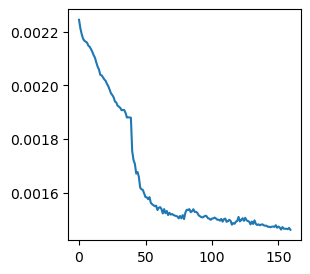

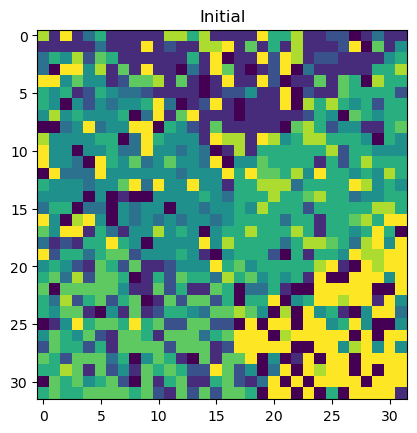

100%|██████████| 1/1 [00:00<00:00, 15.44it/s]


(512, 512)


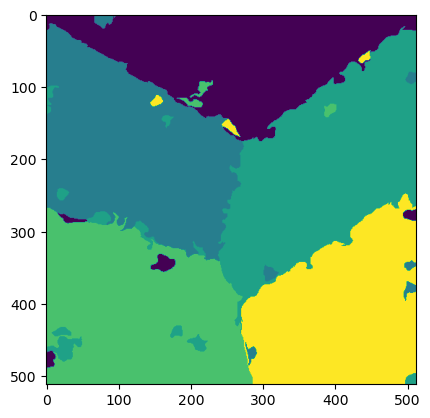

In [239]:
image = np.array(Image.open("synthetic_color_images/0.5/0001.png").resize((512, 512)))[:,:,:3]
k = 10
d = 32
lambda_ = 0.8
segmentor = GNEMS_Segmentor(iterations=4, k=k, d=d, lambda_=lambda_, subset_size=0.5, lr=0.005, epochs=40, n_filters=32, slic_segments=1000, prediction_stride=16, initialization_method="slic")
segmentor.fit(image)
initial = segmentor.initial_labels.detach().cpu().numpy().reshape(segmentor.d, segmentor.d, segmentor.k).argmax(axis=2)

plt.figure(figsize=(3, 3))
plt.plot(segmentor.losses)
plt.show()

plt.title("Initial")
plt.imshow(initial)
plt.show()

seg = segmentor.predict()
print(seg.shape)

plt.imshow(seg)

/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_31676/4246215311.py:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scores_by_noise_level = results_df.groupby("Noise_Level").mean()


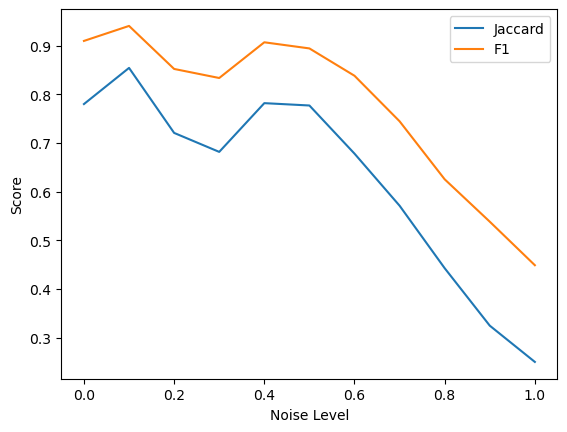

In [211]:
# Noise Experiment
noise_levels = [f'{level:.1f}' for level in np.arange(0, 1.1, 0.1)]
for noise_level in noise_levels:
    print(f"Running noise level {noise_level}...")
    os.makedirs(f"noise_experiment_results/{noise_level}", exist_ok=True)
    for i in tqdm(range(10)):
        image = np.array(Image.open(f"synthetic_color_images/{noise_level}/{i:04d}.png").resize((512, 512)))[:,:,:3]
        segmentor = GNEMS_Segmentor(iterations=4, k=10, d=32, lambda_=0.8, subset_size=0.5, lr=0.005, epochs=40, n_filters=16, slic_segments=1000, prediction_stride=16)
        segmentor.fit(image)
        seg = segmentor.predict(show_progress=False)
        plt.imsave(f"noise_experiment_results/{noise_level}/{i:04d}.png", seg)

results = []
for gt_num in range(10):
    gt_string = f"{gt_num:04d}"
    zero_noise = np.array(Image.open(f"synthetic_color_images/0.0/{gt_string}.png").resize((512, 512)))[:,:,:3]
    colors = np.unique(zero_noise.reshape(512**2,3), axis=0)
    gt = np.zeros((512, 512))
    for i, color in enumerate(colors):
        gt[(zero_noise == color).all(axis=2)] = i
    for noise_level in np.arange(0, 1.1, 0.1):
        noise_level_string = f"{noise_level:.1f}"
        segmentation_image = np.array(Image.open(f"noise_experiment_results/{noise_level_string}/{gt_string}.png"))[:,:,:3]
        colors = np.unique(segmentation_image.reshape(512**2,3), axis=0)
        segmentation_map = np.zeros((512, 512))
        for i, color in enumerate(colors):
            segmentation_map[(segmentation_image == color).all(axis=2)] = i
        jaccard = evaluate.smart_jaccard(gt, segmentation_map)
        f1 = evaluate.smart_f1_score(gt, segmentation_map)
        results.append({"Image_ID": gt_string, "Noise_Level": noise_level, "Jaccard": jaccard, "F1": f1})

results_df = pd.DataFrame(results)
scores_by_noise_level = results_df.groupby("Noise_Level").mean()
plt.plot(scores_by_noise_level.index, scores_by_noise_level["Jaccard"], label="Jaccard")
plt.plot(scores_by_noise_level.index, scores_by_noise_level["F1"], label="F1")
plt.xlabel("Noise Level")
plt.ylabel("Score")
plt.legend()
plt.show()

/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_31676/1046276330.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scores_by_noise_level = results_df.groupby("Patch_Size").mean()


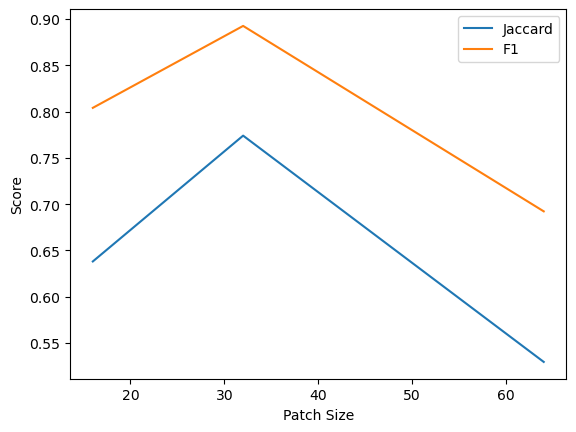

In [218]:
# Patch Size Experiment
patch_sizes = [16,32,64]
for d in patch_sizes:
    print(f"Running noise level {d}...")
    os.makedirs(f"patch_size_experiment_results/{d}", exist_ok=True)
    for i in tqdm(range(10)):
        image = np.array(Image.open(f"synthetic_color_images/0.4/{i:04d}.png").resize((512, 512)))[:,:,:3]
        for trial_num in range(3):
            segmentor = GNEMS_Segmentor(iterations=4, k=10, d=d, lambda_=0.8, subset_size=0.5, lr=0.005, epochs=40, n_filters=16, slic_segments=1000, prediction_stride=16)
            segmentor.fit(image)
            seg = segmentor.predict(show_progress=False)
            plt.imsave(f"patch_size_experiment_results/{d}/{i:04d}_{trial_num:02d}.png", seg)

results = []
for gt_num in range(10):
    gt_string = f"{gt_num:04d}"
    zero_noise = np.array(Image.open(f"synthetic_color_images/0.0/{gt_string}.png").resize((512, 512)))[:,:,:3]
    colors = np.unique(zero_noise.reshape(512**2,3), axis=0)
    gt = np.zeros((512, 512))
    for i, color in enumerate(colors):
        gt[(zero_noise == color).all(axis=2)] = i
    for d in patch_sizes:
        for trial_num in range(3):
            segmentation_image = np.array(Image.open(f"patch_size_experiment_results/{d}/{gt_string}_{trial_num:02d}.png"))[:,:,:3]
            colors = np.unique(segmentation_image.reshape(512**2,3), axis=0)
            segmentation_map = np.zeros((512, 512))
            for i, color in enumerate(colors):
                segmentation_map[(segmentation_image == color).all(axis=2)] = i
            jaccard = evaluate.smart_jaccard(gt, segmentation_map)
            f1 = evaluate.smart_f1_score(gt, segmentation_map)
            results.append({"Image_ID": gt_string, "Patch_Size": d, "Jaccard": jaccard, "F1": f1})

results_df = pd.DataFrame(results)
scores_by_noise_level = results_df.groupby("Patch_Size").mean()
plt.plot(scores_by_noise_level.index, scores_by_noise_level["Jaccard"], label="Jaccard")
plt.plot(scores_by_noise_level.index, scores_by_noise_level["F1"], label="F1")
plt.xlabel("Patch Size")
plt.ylabel("Score")
plt.legend()
plt.show()

/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_31676/912017140.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scores_by_noise_level = results_df.groupby("n_epochs").mean()


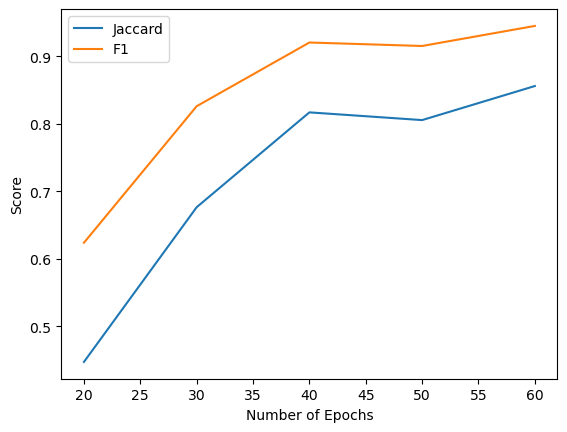

In [220]:
# Epoch Experiment
n_epoch_options = [20,30,40,50,60]
for n_epochs in n_epoch_options:
    print(f"Running number of epochs = {n_epochs}...")
    os.makedirs(f"epoch_experiment_results/{n_epochs}", exist_ok=True)
    for i in tqdm(range(10)):
        image = np.array(Image.open(f"synthetic_color_images/0.4/{i:04d}.png").resize((512, 512)))[:,:,:3]
        for trial_num in range(3):
            segmentor = GNEMS_Segmentor(iterations=4, k=10, d=32, lambda_=0.8, subset_size=0.5, lr=0.005, epochs=n_epochs, n_filters=16, slic_segments=1000, prediction_stride=16)
            segmentor.fit(image)
            seg = segmentor.predict(show_progress=False)
            plt.imsave(f"epoch_experiment_results/{n_epochs}/{i:04d}_{trial_num:02d}.png", seg)

results = []
for gt_num in range(10):
    gt_string = f"{gt_num:04d}"
    zero_noise = np.array(Image.open(f"synthetic_color_images/0.0/{gt_string}.png").resize((512, 512)))[:,:,:3]
    colors = np.unique(zero_noise.reshape(512**2,3), axis=0)
    gt = np.zeros((512, 512))
    for i, color in enumerate(colors):
        gt[(zero_noise == color).all(axis=2)] = i
    for n_epochs in n_epoch_options:
        for trial_num in range(3):
            segmentation_image = np.array(Image.open(f"epoch_experiment_results/{n_epochs}/{gt_string}_{trial_num:02d}.png"))[:,:,:3]
            colors = np.unique(segmentation_image.reshape(512**2,3), axis=0)
            segmentation_map = np.zeros((512, 512))
            for i, color in enumerate(colors):
                segmentation_map[(segmentation_image == color).all(axis=2)] = i
            jaccard = evaluate.smart_jaccard(gt, segmentation_map)
            f1 = evaluate.smart_f1_score(gt, segmentation_map)
            results.append({"Image_ID": gt_string, "n_epochs": n_epochs, "Jaccard": jaccard, "F1": f1})

results_df = pd.DataFrame(results)
scores_by_noise_level = results_df.groupby("n_epochs").mean()
plt.plot(scores_by_noise_level.index, scores_by_noise_level["Jaccard"], label="Jaccard")
plt.plot(scores_by_noise_level.index, scores_by_noise_level["F1"], label="F1")
plt.xlabel("Number of Epochs")
plt.ylabel("Score")
plt.legend()
plt.show()

/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_31676/2449640320.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scores_by_noise_level = results_df.groupby("n_filters").mean()


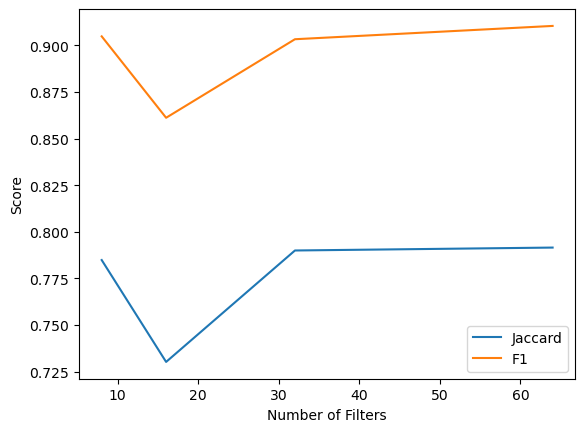

In [226]:
# Filter Experiment
n_filter_options = [8,16,32,64]
for n_filters in n_filter_options:
    print(f"Running number of filters = {n_filters}...")
    os.makedirs(f"filter_experiment_results/{n_filters}", exist_ok=True)
    for i in tqdm(range(10)):
        image = np.array(Image.open(f"synthetic_color_images/0.4/{i:04d}.png").resize((512, 512)))[:,:,:3]
        for trial_num in range(3):
            segmentor = GNEMS_Segmentor(iterations=4, k=10, d=32, lambda_=0.8, subset_size=0.5, lr=0.005, epochs=40, n_filters=n_filters, slic_segments=1000, prediction_stride=16)
            segmentor.fit(image)
            seg = segmentor.predict(show_progress=False)
            plt.imsave(f"filter_experiment_results/{n_filters}/{i:04d}_{trial_num:02d}.png", seg)

results = []
for gt_num in range(10):
    gt_string = f"{gt_num:04d}"
    zero_noise = np.array(Image.open(f"synthetic_color_images/0.0/{gt_string}.png").resize((512, 512)))[:,:,:3]
    colors = np.unique(zero_noise.reshape(512**2,3), axis=0)
    gt = np.zeros((512, 512))
    for i, color in enumerate(colors):
        gt[(zero_noise == color).all(axis=2)] = i
    for n_filters in n_filter_options:
        for trial_num in range(3):
            segmentation_image = np.array(Image.open(f"filter_experiment_results/{n_filters}/{gt_string}_{trial_num:02d}.png"))[:,:,:3]
            colors = np.unique(segmentation_image.reshape(512**2,3), axis=0)
            segmentation_map = np.zeros((512, 512))
            for i, color in enumerate(colors):
                segmentation_map[(segmentation_image == color).all(axis=2)] = i
            jaccard = evaluate.smart_jaccard(gt, segmentation_map)
            f1 = evaluate.smart_f1_score(gt, segmentation_map)
            results.append({"Image_ID": gt_string, "n_filters": n_filters, "Jaccard": jaccard, "F1": f1})

results_df = pd.DataFrame(results)
scores_by_noise_level = results_df.groupby("n_filters").mean()
plt.plot(scores_by_noise_level.index, scores_by_noise_level["Jaccard"], label="Jaccard")
plt.plot(scores_by_noise_level.index, scores_by_noise_level["F1"], label="F1")
plt.xlabel("Number of Filters")
plt.ylabel("Score")
plt.legend()
plt.show()

In [ ]:
# Fix graph (start here)
# start with code sent to jeova a while ago

# Try some experiments with synthetic data (without graph but eventually with graph)
# Noise
# Patch size
# Number of epochs
# Number of filters

# Try random initialization
# Make sure clusters are average

# Meetings tuesdays at 3